# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [2]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [3]:
# Define transforms
training_transforms = transforms.Compose([transforms.RandomRotation(25),
                                          transforms.RandomResizedCrop(28),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5, 0.5, 0.5), 
                                                               (0.5, 0.5, 0.5))])
testing_transforms = transforms.Compose([transforms.Resize(30),
                                         transforms.CenterCrop(28),
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), 
                                                              (0.5, 0.5, 0.5))])

# Create training set and define training dataloader
training_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=training_transforms, download=True)
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=64, shuffle=True)

# Create test set and define test dataloader
testing_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=testing_transforms, download=True)
test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=64, shuffle=True)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [4]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
        
        # Un-normalize
        image = images[i]/2 + 0.5
        image = image.numpy()
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()

cat


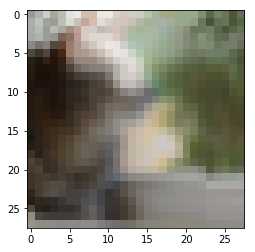

bird


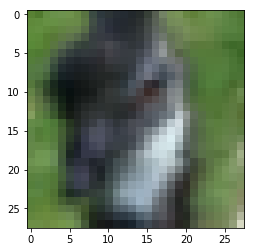

bird


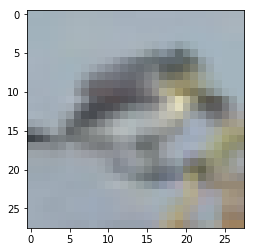

plane


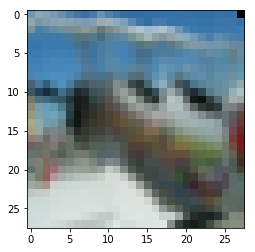

ship


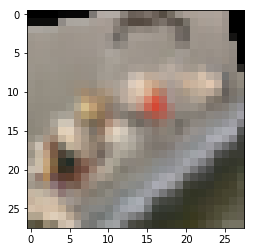

In [5]:
# Explore data
show5(train_loader)

plane


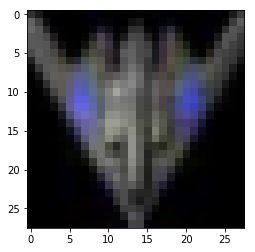

deer


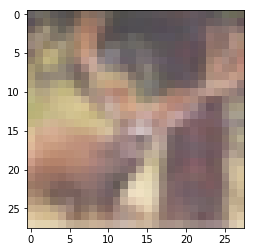

cat


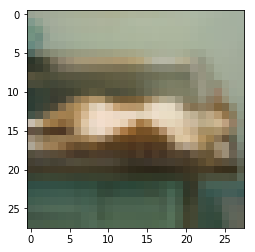

dog


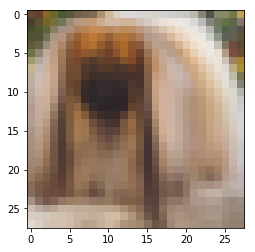

deer


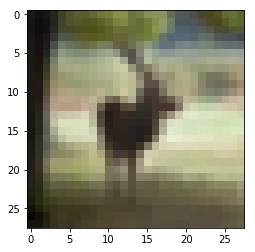

In [6]:
show5(test_loader)

In [7]:
print(f'Training Batches #: {len(train_loader)}')
print(f'Testing Batches #: {len(test_loader)}')

Training Batches #: 782
Testing Batches #: 157


In [8]:
batch = iter(test_loader).next()
data = batch[0].shape
label = batch[1].shape
print(data)
print(label)
print(batch[0].view(64, -1).shape)

# Size of train/test data

torch.Size([64, 3, 28, 28])
torch.Size([64])
torch.Size([64, 2352])


One batch has 64 images. Each image has 3 channels (RGB) and is of 28 x 28 = 784 pixels in size. Input to the network is thus 3*784 = 2352.

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [9]:
class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super().__init__()
        
        self.fc_input = nn.Linear(input_size, hidden_size[0])
        self.fc_hidden = nn.ModuleList([])
        
        for i in range(len(hidden_size)-1):
            self.fc_hidden.extend([nn.Linear(hidden_size[i], hidden_size[i+1])])
        
        self.fc_output = nn.Linear(hidden_size[-1], output_size)
    
    def forward(self, x):
        x = x.view(x.shape[0], -1)

        x = F.relu(self.fc_input(x))
        for i in range(len(hidden_size)-1):
            x = F.relu(self.fc_hidden[i](x))
        x = F.log_softmax(self.fc_output(x), dim=1)

        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [15]:
input_size = 2352
output_size = 10
hidden_size = [1024, 512, 256, 64]
model = Network(input_size, output_size, hidden_size)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [20]:
model

Network(
  (fc_input): Linear(in_features=2352, out_features=1024, bias=True)
  (fc_hidden): ModuleList(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=64, bias=True)
  )
  (fc_output): Linear(in_features=64, out_features=10, bias=True)
)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_loss = []
test_loss = []
test_accuracy = []
epochs = 40

model.to(device)

for e in range(epochs):
    model.train()
    training_loss = 0
    testing_loss = 0
    testing_accuracy = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
     
        logps = model.forward(images)
        loss = criterion(logps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        training_loss += loss.item()
        
    else:
        model.eval()
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)

                logps = model.forward(images)
                loss = criterion(logps, labels)

                ps = torch.exp(logps)
                prob, prob_class = ps.topk(1, dim=1)
                equals = prob_class == labels.view(prob_class.shape)
                accuracy = torch.mean(equals.type(torch.FloatTensor))

                testing_loss += loss.item()
                testing_accuracy += accuracy.item()
    
    train_loss.append(training_loss/len(train_loader))
    test_loss.append(testing_loss/len(test_loader))
    test_accuracy.append(testing_accuracy/len(test_loader))
    
    print(f'Epoch: {e+1}/{epochs} ...' 
          f'Training Loss: {training_loss/len(train_loader):.04f} ...'
          f'Testing Loss: {testing_loss/len(test_loader):.04f} ...'
          f'Test Accuracy: {testing_accuracy/len(test_loader):.04f}')

Epoch: 1/40 ...Training Loss: 2.2988 ...Testing Loss: 2.2896 ...Test Accuracy: 0.1698
Epoch: 2/40 ...Training Loss: 2.2626 ...Testing Loss: 2.1852 ...Test Accuracy: 0.2136
Epoch: 3/40 ...Training Loss: 2.1182 ...Testing Loss: 2.0106 ...Test Accuracy: 0.2600
Epoch: 4/40 ...Training Loss: 2.0362 ...Testing Loss: 1.9474 ...Test Accuracy: 0.2911
Epoch: 5/40 ...Training Loss: 1.9937 ...Testing Loss: 1.8827 ...Test Accuracy: 0.3161
Epoch: 6/40 ...Training Loss: 1.9558 ...Testing Loss: 1.8268 ...Test Accuracy: 0.3390
Epoch: 7/40 ...Training Loss: 1.9239 ...Testing Loss: 1.7893 ...Test Accuracy: 0.3571
Epoch: 8/40 ...Training Loss: 1.9002 ...Testing Loss: 1.7472 ...Test Accuracy: 0.3775
Epoch: 9/40 ...Training Loss: 1.8758 ...Testing Loss: 1.7204 ...Test Accuracy: 0.3889
Epoch: 10/40 ...Training Loss: 1.8503 ...Testing Loss: 1.6768 ...Test Accuracy: 0.4040
Epoch: 11/40 ...Training Loss: 1.8309 ...Testing Loss: 1.6561 ...Test Accuracy: 0.4076
Epoch: 12/40 ...Training Loss: 1.8178 ...Testing Los

Plot the training loss (and validation loss/accuracy, if recorded).

Text(0.5,1,'Test Accuracy')

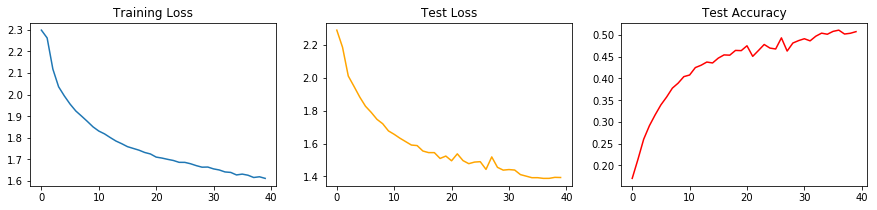

In [17]:
plt.figure(figsize=[15,3])
plt.subplot(1, 3, 1)
plt.plot(train_loss)
plt.title('Training Loss')
plt.subplot(1, 3, 2)
plt.plot(test_loss, color='orange')
plt.title('Test Loss')
plt.subplot(1, 3, 3)
plt.plot(test_accuracy, color='red')
plt.title('Test Accuracy')

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [21]:
model.eval()
avg_accuracy = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        logps = model.forward(images)
        loss = criterion(logps, labels)

        ps = torch.exp(logps)
        prob, prob_class = ps.topk(1, dim=1)
        equals = prob_class == labels.view(prob_class.shape)
        accuracy = torch.mean(equals.type(torch.FloatTensor))

        avg_accuracy += accuracy.item()

avg_accuracy *= 100
print(f'Model Test Accuracy: {(avg_accuracy/len(test_loader)):.02f}')

Model Test Accuracy: 50.78


## Saving your model
Using `torch.save`, save your model for future loading.

In [22]:
checkpoint = {'input': input_size,
              'output': output_size, 
              'hidden': hidden_size,
              'state_dict': model.state_dict()
             }
torch.save(checkpoint, 'checkpoint.pth')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?

My recommendation is to build a model in-house.
<br>1. The model achieves an accuracy of 50.7%, 5.7% more than that of the Detectocorp's model. Due to higher accuracy, using an in-house model is better than buying Detectocorp's. We also avoid costs by not buying a less performing model.
<br>2. The model is not as good as the advanced solutions in literature. It does not perform as well as them since it does not use Convolutional Layers, which are considered good for images. It also only has 3 hidden layers and is not as deep as advanced networks.
<br>3. I adjusted the learning rate, number of neurons in the hidden layers, and the number of epochs.
<br>4. Yes, since it much lesser than 70%. Improving the accuracy may require using more parameters/layers, using convolutional layers, or training for longer number of epochs.

## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).